# Practical Lesson on Climate Data Analysis 2
### Matteo Mastropierro and Davide Zanchettin

- see xarray tutorial repo at: https://github.com/xarray-contrib/xarray-tutorial.git

## Model - Observation BIAS

The CMCC-ESM2 model we are working with at is NOT a perfect representation of reality, because of the inherent missing physical representation of some processes. What we want to examine here is the deviation this model has from the (quasi-) observations of ERA5 reanalysis.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cftime 
import warnings
warnings.filterwarnings('ignore')

#%matplotlib inline
#%config InlineBackend.figure_format='retina'

Load the historical ESM simulation 

In [2]:
path = 'C:/Users/mastr/Documents/Climate Data Lesson_Oct 2022/tas_Amon_CMCC-ESM2_historical_r1i1p1f1_gn_185001-201412.nc'
ds_hist = xr.load_dataset(path)
ds_hist

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
    lat_bnds   (lat, bnds) float64 -90.0 -89.53 -89.53 ... 89.53 89.53 90.0
    lon_bnds   (lon, bnds) float64 -0.625 0.625 0.625 ... 358.1 358.1 359.4
    tas        (time, lat, lon) float32 250.6 251.8 250.5 ... 260.5 260.5 260.5
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                none
    ...                     ...
    title:                  CMCC-ESM2 output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/db148e8f-76e1-424c-92e0-8f5abb588c13

Load the ERA5 Reanalysis

In [3]:
path = 'C:/Users/mastr/Documents/Climate Data Lesson_Oct 2022/ta_era5_mon_1985-2014.nc'
ds_rean = xr.load_dataset(path)
ds_rean

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 348)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1985-01-01 1985-02-01 ... 2014-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 251.0 251.0 ... 246.2 246.2
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-03 16:28:59 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Look at the different configuration of the two Dataset. For ESM, our variable of interest is called `tas`, whereas for the reanalysis it is called `t2m`.

Coordinates are also named differently (eg `lat` vs `latitude`) and stored in a different order.

In [4]:
# Renaming longitude and latitude variables

ds_rean = ds_rean.rename(longitude="lon")
ds_rean = ds_rean.rename(latitude="lat")
ds_rean = ds_rean.rename(t2m="tas")
ds_rean

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 721, time: 348)
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time     (time) datetime64[ns] 1985-01-01 1985-02-01 ... 2014-12-01
Data variables:
    tas      (time, lat, lon) float32 251.0 251.0 251.0 ... 246.2 246.2 246.2
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-03 16:28:59 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

If we want to compare the two Datasets, what we need is them to have the same dimensions (Time, Lon and Lat)

In [5]:
# Here we show the resolution of both ESM and Reanalysis
# by looking at the difference among two longitudinal steps

display(ds_rean.lon[1] - ds_rean.lon[0])
display(ds_hist.lon[1] - ds_hist.lon[0])

<xarray.DataArray 'lon' ()>
array(0.25, dtype=float32)

<xarray.DataArray 'lon' ()>
array(1.25)
Coordinates:
    height   float64 2.0

In [6]:
# Here we show the resolution of both ESM and Reanalysis
# by looking at the difference among two latitudinal steps

display(ds_rean.lat[1] - ds_rean.lat[0])
display(ds_hist.lat[1] - ds_hist.lat[0])

<xarray.DataArray 'lat' ()>
array(-0.25, dtype=float32)

<xarray.DataArray 'lat' ()>
array(0.94240838)
Coordinates:
    height   float64 2.0

In oder to get the same Spatial Resolution (Lat-Lon), we need to process our data through an interpolation algorithm, which allows us to have as a results a Dataset with the same number of Lon and Lat Coordinates (and thus the same resolution!)

In [ ]:
import xesmf as xe

new_lon = (ds_hist.lon[1] - ds_hist.lon[0])
new_lat = (ds_hist.lat[1] - ds_hist.lat[0])

# ds_out = xe.util.cf_grid_2d(ds_rean.lon[0], ds_rean.lon[-1], new_lon, ds_rean.lat[0], ds_rean.lat[-1], new_lat)

# Bilinear regridding algorithm
# Other algorithms too 

regrid_rean = xe.Regridder(ds_rean, ds_hist, "bilinear")

ds_rean = regrid_rean(ds_rean, keep_attrs=True)

display(ds_rean)

<xarray.Dataset>
Dimensions:  (time: 348, lat: 192, lon: 288)
Coordinates:
  * time     (time) datetime64[ns] 1985-01-01 1985-02-01 ... 2014-12-01
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    tas      (time, lat, lon) float64 243.3 243.3 243.3 ... 252.5 252.5 252.5
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-03 16:28:59 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [8]:
# Define Variable an convert Kelvn to Celsius

var = "tas"

ds_hist[var] = ds_hist[var] - 273.15
ds_rean[var] = ds_rean[var] - 273.15

Text(0.5, 0, 'K')

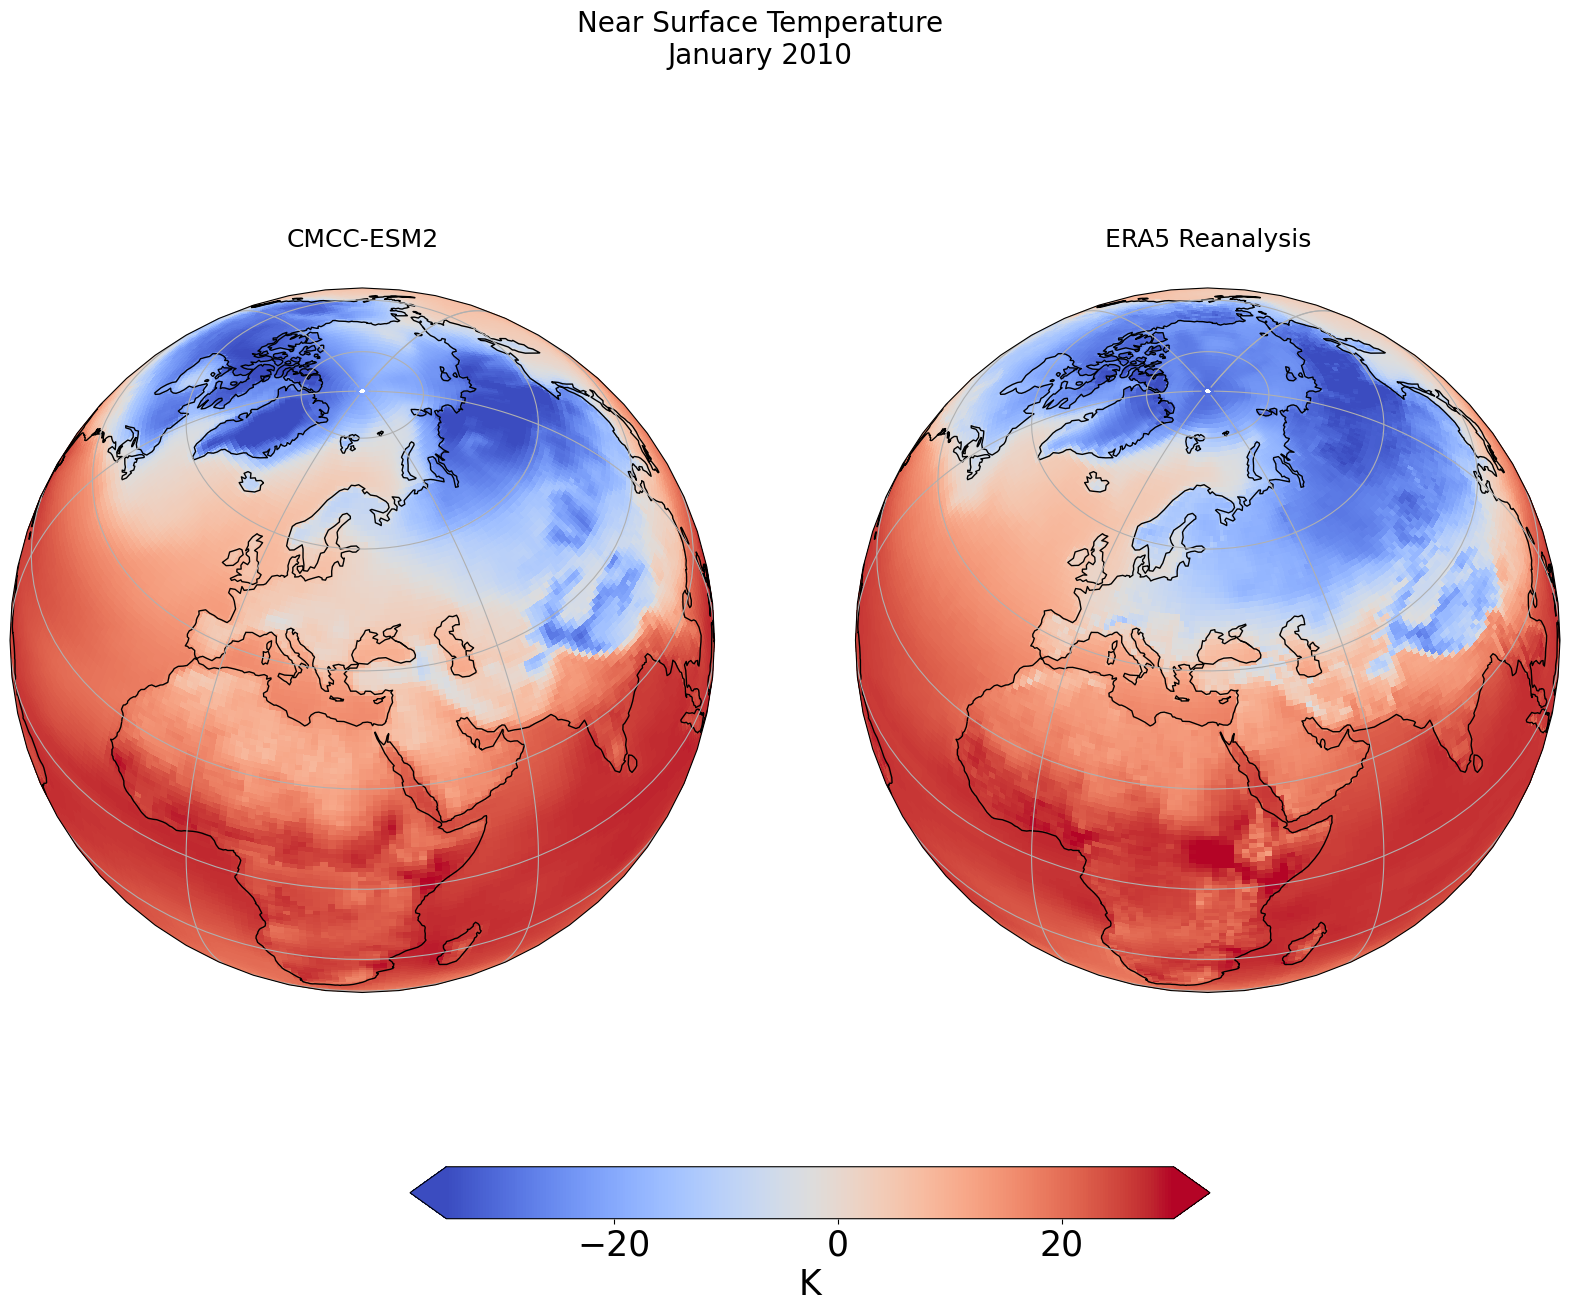

In [9]:
fig = plt.figure(1, figsize=[20,13])

# Set the projection to use for plotting
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(30, 45))
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(30, 45))

# Fix extent
minval = -35
maxval = 30

tsel = "2010-01"

map = ds_hist[var].sel(time=tsel).mean("time").plot(ax=ax1, vmin=minval, vmax=maxval, 
                                           transform=ccrs.PlateCarree(), 
                                           cmap='coolwarm', 
                                           add_colorbar=False)

map = ds_rean[var].sel(time=tsel).mean("time").plot(ax=ax2, vmin=minval, vmax=maxval, 
                                           transform=ccrs.PlateCarree(), 
                                           cmap='coolwarm', 
                                           add_colorbar=False)



ax1.set_title(ds_hist.attrs['parent_source_id'] , fontsize=18, pad = 30)
ax1.coastlines()
ax1.gridlines()

ax2.set_title("ERA5 Reanalysis" , fontsize=18, pad = 30)
ax2.coastlines()
ax2.gridlines()

# Title for both plots
fig.suptitle('Near Surface Temperature\n' + ds_hist[var].sel(time=tsel).time.values[0].strftime("%B %Y"), fontsize=20)


cb_ax = fig.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_xlabel('K', fontsize=25)

Now we want to calculate the BIAS, so the deviation of the ESM from the quasi-observation of ERA5

In [10]:
# To compute the difference, we need not only Longitude and Latitude to have the same resolution
# but also the Dataarray need to have the same calendar!

ds_hist.indexes['time']
ds_rean.indexes['time']

DatetimeIndex(['1985-01-01', '1985-02-01', '1985-03-01', '1985-04-01',
               '1985-05-01', '1985-06-01', '1985-07-01', '1985-08-01',
               '1985-09-01', '1985-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', name='time', length=348, freq=None)

In [11]:
# We can (luckily) easily convert our ESM cftime object to a standard datetime calendar 

ds_hist['time'] = ds_hist.indexes['time'].to_datetimeindex()

In [12]:
# Let's compute the monthly bias


bias = ds_hist.sel(time=slice("1985-01", "2012-12"))[var].groupby("time.month").mean() - ds_rean.sel(time=slice("1985-01", "2012-12"))[var].groupby("time.month").mean()

In [13]:
bias.sel(month=1)

<xarray.DataArray 'tas' (lat: 192, lon: 288)>
array([[ 8.65590733,  8.76404828,  8.56444424, ...,  8.75397557,
         9.31670636,  8.70721119],
       [14.0681858 , 11.50277353, 11.98273444, ..., 11.67199628,
        11.79183814, 11.25230189],
       [15.91390336, 15.94511761, 15.83274181, ..., 15.88710821,
        15.65566045, 15.85590338],
       ...,
       [ 2.3993585 ,  2.41353178,  2.4223739 , ...,  2.29785236,
         2.34600908,  2.37785964],
       [ 2.57404525,  2.56697414,  2.56006778, ...,  2.59082138,
         2.58507338,  2.57939328],
       [ 2.88894555,  2.89032838,  2.89136979, ...,  2.88143823,
         2.88468454,  2.8871145 ]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    height   float64 2.0
    month    int64 1

Text(0.5, 0, 'K')

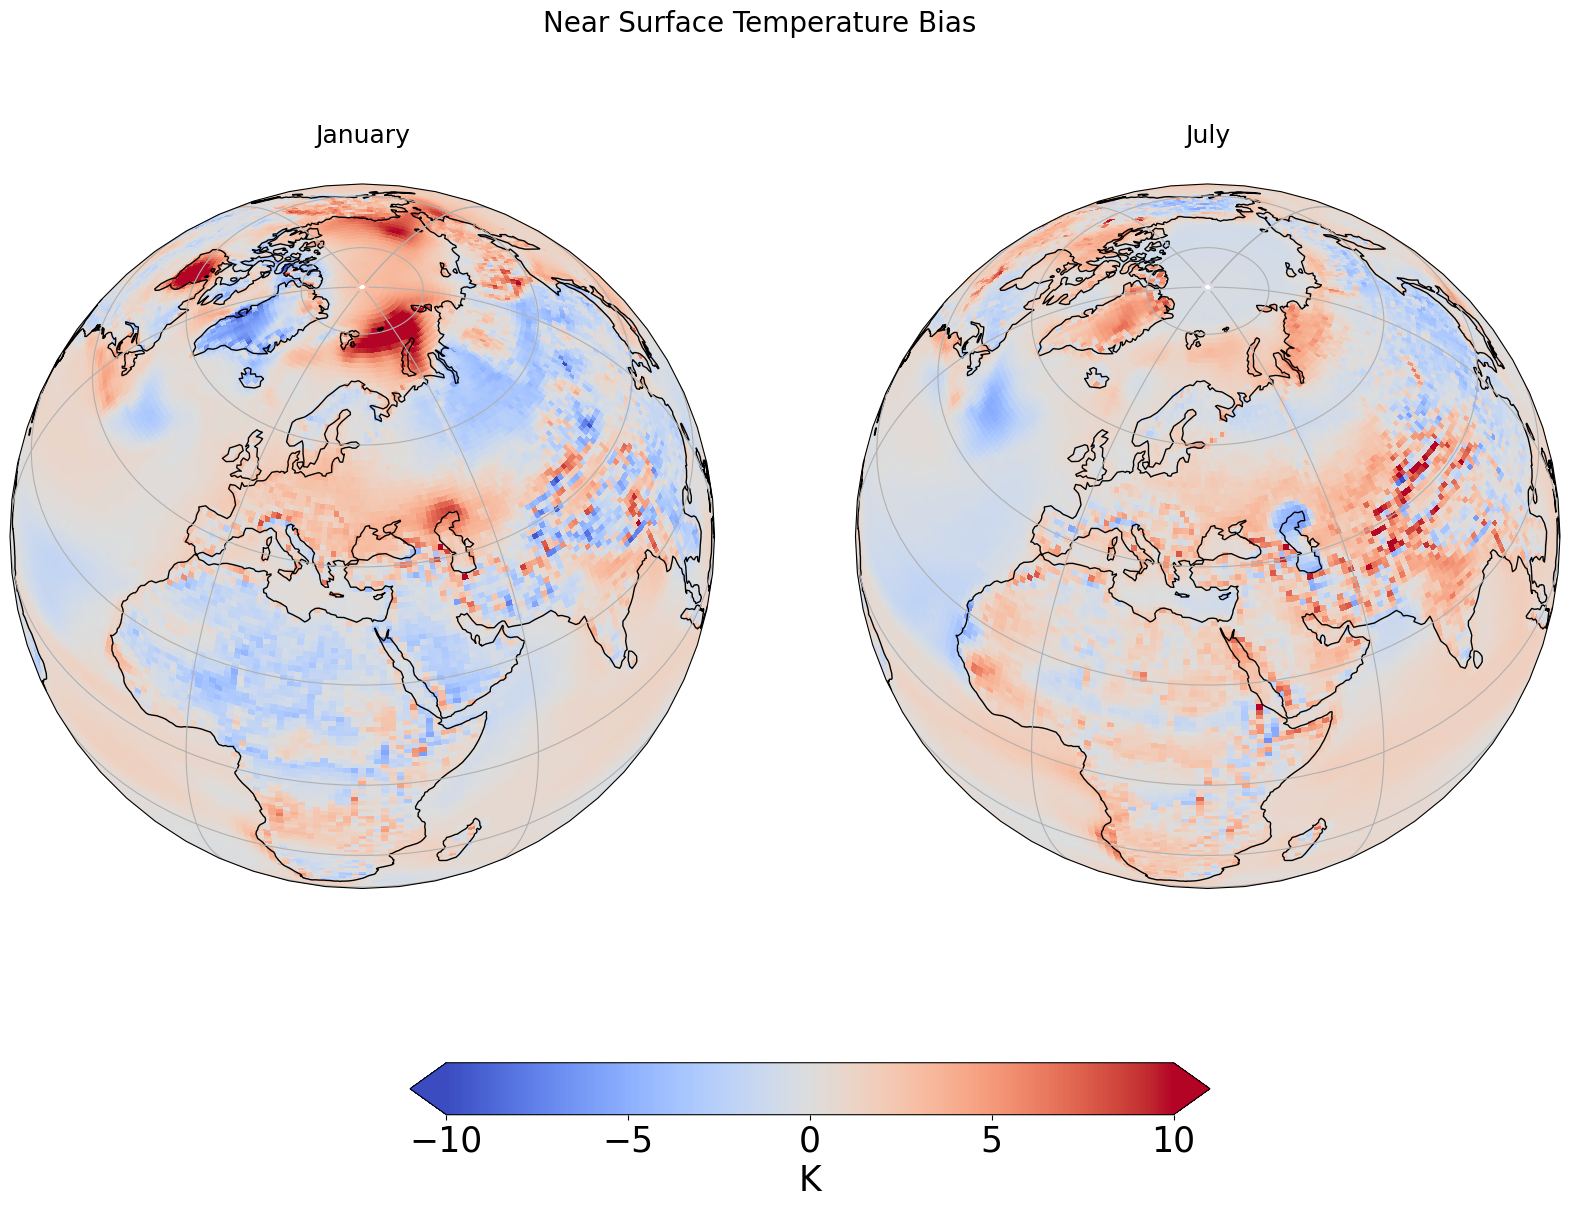

In [14]:
fig = plt.figure(1, figsize=[20,13])

# Set the projection to use for plotting
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(30, 45))
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(30, 45))

# Fix MIN and MAX colorbar extent
minval = -10
maxval = 10

map = bias.sel(month =1).plot(ax=ax1, vmin=minval, vmax=maxval, 
                                           transform=ccrs.PlateCarree(), 
                                           cmap='coolwarm', 
                                           add_colorbar=False)

map = bias.sel(month = 6).plot(ax=ax2, vmin=minval, vmax=maxval, 
                                           transform=ccrs.PlateCarree(), 
                                           cmap='coolwarm', 
                                           add_colorbar=False)



ax1.set_title("January" , fontsize=18, pad = 30)
ax1.coastlines()
ax1.gridlines()

ax2.set_title("July" , fontsize=18, pad = 30)
ax2.coastlines()
ax2.gridlines()

# Title for both plots
fig.suptitle('Near Surface Temperature Bias', fontsize=20, y = 0.9)


cb_ax = fig.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046)
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_xlabel('K', fontsize=25)

# Historical - SSP245 scenario

Now, let's take a look at what the temperature could look like in a medium increase warming scenario, the SSP245.

In [15]:
# Import SSP245 and convert from Kelvin to Celsius

path = 'C:/Users/mastr/Documents/Climate Data Lesson_Oct 2022/tas_Amon_CMCC-ESM2_ssp245_r1i1p1f1_gn_201501-210012.nc'
ds_ssp = xr.load_dataset(path)
ds_ssp[var].data = ds_ssp[var].data - 273.15
ds_ssp['time'] = ds_ssp.indexes['time'].to_datetimeindex()
ds_ssp

<xarray.Dataset>
Dimensions:    (time: 1032, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 2015-01-01 00:00:00 ... 2101-01-01 00:00:00
    lat_bnds   (lat, bnds) float64 -90.0 -89.53 -89.53 ... 89.53 89.53 90.0
    lon_bnds   (lon, bnds) float64 -0.625 0.625 0.625 ... 358.1 358.1 359.4
    tas        (time, lat, lon) float32 -19.72 -19.55 -19.83 ... 0.5884 0.5883
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comment:                none
    ...                     ...
    title:                  CMCC-ESM2 output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/90a9919e-6c68-4b66-98a7-4382e9f799b3

We can take the end of the century climatology (2070-2100) of the SSP245 dataset and compare it with the historical climatology (1980-2010) from the CMCC-ESM2 model.

This step is analogous to the bias calculation we have performed before, but now we are confronting the same model but two different time periods!

In [16]:
ds_diff = ds_ssp.sel(time=slice("2070-01", "2099-12"))[var].groupby("time.season").mean() - ds_hist.sel(time=slice("1980-01", "2009-12"))[var].groupby("time.season").mean()
ds_diff

<xarray.DataArray 'tas' (season: 4, lat: 192, lon: 288)>
array([[[ 7.4122486,  7.393715 ,  7.4523163, ...,  5.9645004,
          6.999174 ,  7.4496803],
        [ 3.0388908,  5.2515335,  4.531006 , ...,  3.739874 ,
          5.0561466,  3.8907108],
        [ 2.692894 ,  2.721428 ,  2.9529285, ...,  2.7450924,
          3.0816536,  2.8213234],
        ...,
        [20.362923 , 20.341501 , 20.323875 , ..., 20.466036 ,
         20.423122 , 20.389505 ],
        [20.518505 , 20.518457 , 20.518402 , ..., 20.518614 ,
         20.518576 , 20.518534 ],
        [20.557419 , 20.555984 , 20.554941 , ..., 20.565527 ,
         20.561981 , 20.559362 ]],

       [[ 3.0797386,  3.056034 ,  3.1003532, ...,  3.2413063,
          3.0459824,  3.0521812],
        [ 3.3839073,  3.1441574,  3.1708221, ...,  3.3774223,
          3.1475754,  3.3968048],
        [ 3.4776154,  3.458065 ,  3.4352417, ...,  3.5151749,
          3.4802208,  3.4877205],
...
        [14.354145 , 14.343781 , 14.335268 , ..., 14.40522  ,
         14.383854 , 14.367145 ],
        [14.436327 , 14.436434 , 14.436551 , ..., 14.436049 ,
         14.43613  , 14.436229 ],
        [14.479892 , 14.47914  , 14.478658 , ..., 14.484628 ,
         14.482504 , 14.480974 ]],

       [[ 2.9126625,  2.8987427,  2.9760857, ...,  2.691082 ,
          2.8019447,  2.9390106],
        [ 2.2629356,  2.6503296,  2.5005798, ...,  2.3850899,
          2.570366 ,  2.443592 ],
        [ 2.2873   ,  2.313099 ,  2.435009 , ...,  2.3709068,
          2.4849014,  2.3721542],
        ...,
        [ 5.889433 ,  5.885221 ,  5.881638 , ...,  5.905778 ,
          5.8993416,  5.8941803],
        [ 5.869754 ,  5.8692203,  5.868638 , ...,  5.871085 ,
          5.8706865,  5.87024  ],
        [ 5.8202276,  5.819487 ,  5.818809 , ...,  5.823106 ,
          5.821984 ,  5.821046 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    height   float64 2.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

Let's visualize the expected warming by the end of the century, for both Winter and Summer seasons

Text(0.5, 0, '°C')

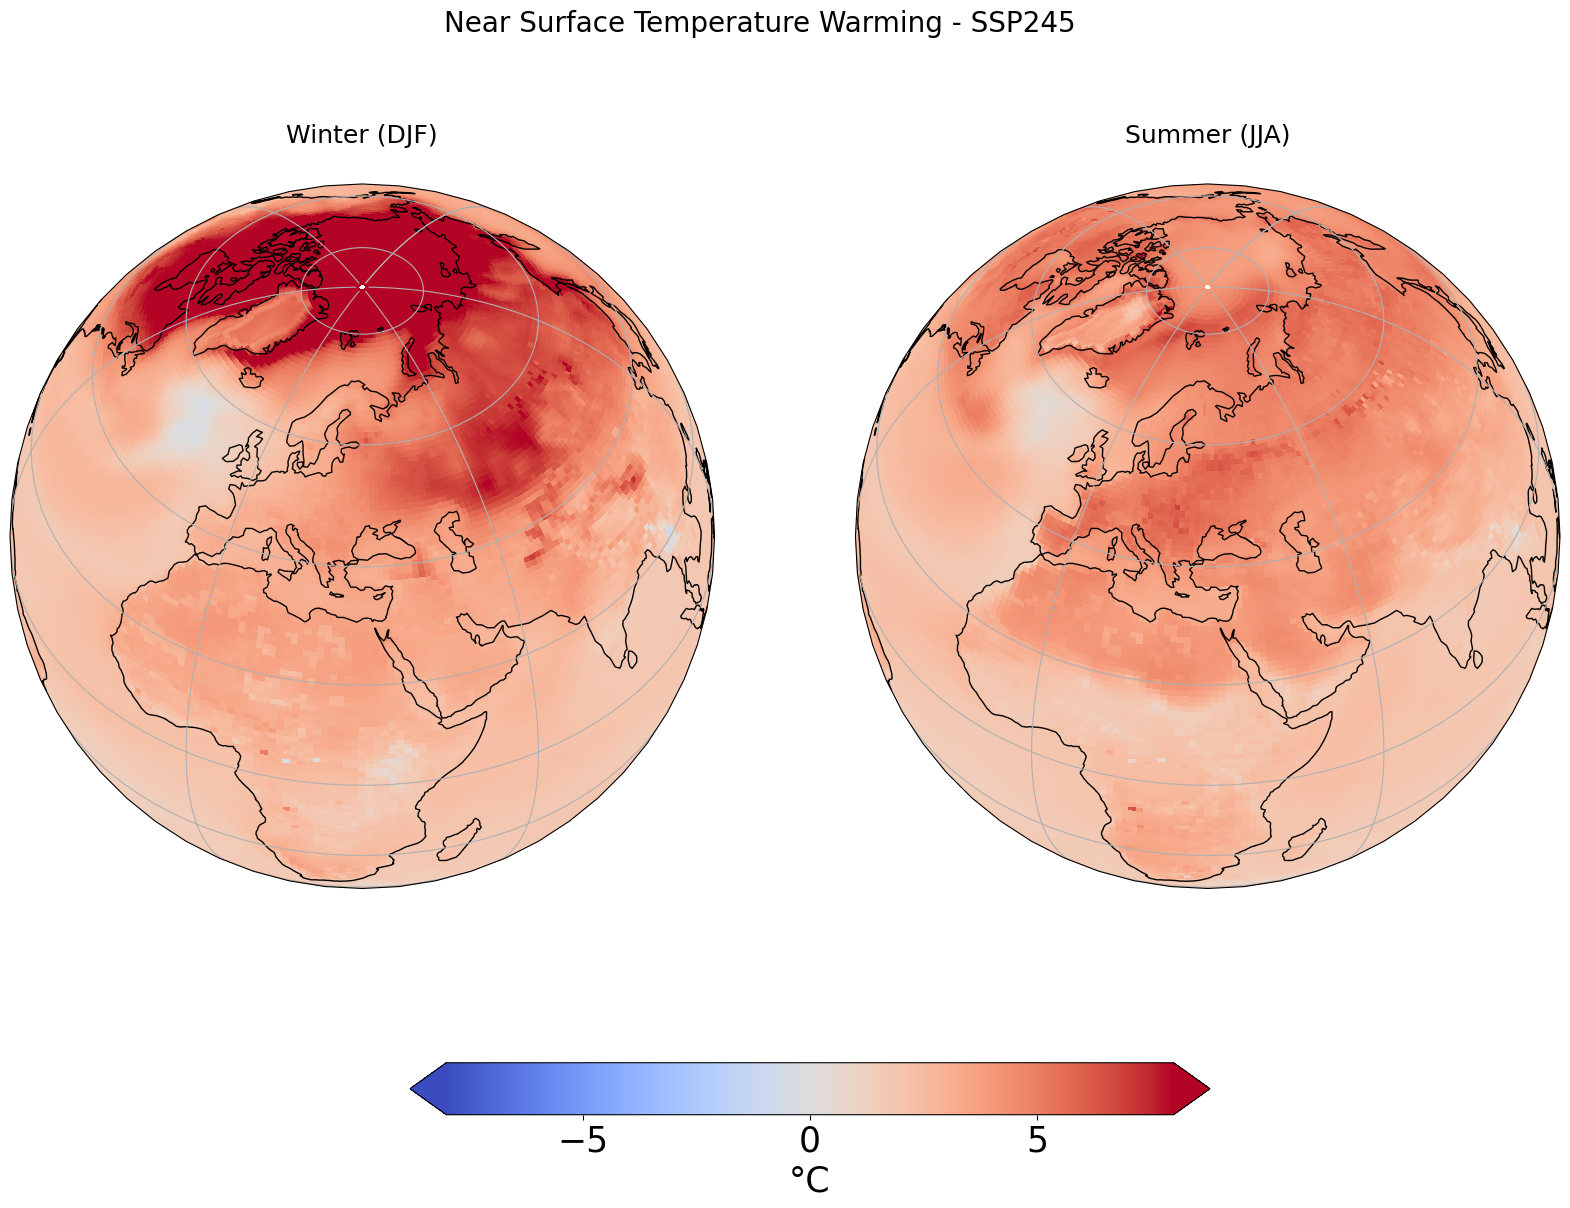

In [17]:
fig = plt.figure(1, figsize=[20,13])

# Set the projection to use for plotting
ax1 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(30, 45))
ax2 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(30, 45))

# Fix MIN and MAX colorbar extent
minval = -8
maxval = 8

map = ds_diff.sel(season = 'DJF').plot(ax=ax1, vmin=minval, vmax=maxval, 
                                           transform=ccrs.PlateCarree(), 
                                           cmap='coolwarm', 
                                           add_colorbar=False)

map = ds_diff.sel(season = 'JJA').plot(ax=ax2, vmin=minval, vmax=maxval, 
                                           transform=ccrs.PlateCarree(), 
                                           cmap='coolwarm', 
                                           add_colorbar=False)



ax1.set_title("Winter (DJF)" , fontsize=18, pad = 30)
ax1.coastlines()
ax1.gridlines()

ax2.set_title("Summer (JJA)" , fontsize=18, pad = 30)
ax2.coastlines()
ax2.gridlines()

# Title for both plots
fig.suptitle('Near Surface Temperature Warming - SSP245', fontsize=20, y = 0.9)


cb_ax = fig.add_axes([0.325, 0.05, 0.4, 0.04])

cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046)
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_xlabel('°C', fontsize=25)

The global mean warming trend it's clear, both in the Winter Season and in the SUmmer Season. Can you guess why the Arctic region it's so affected by global warming?

Try to change the Summer map projection center to Longitude -30 and Latitude 45 (line 5, ax2 = xxxxx)...What do you notice?

### Mean Temperature trends throughout the 21st century

First, concatenate together the historical and future DataArrays (ds_hist & ds_ssp) along the `time` dimension

In [18]:
ds_all = xr.concat([ds_hist, ds_ssp], dim = "time")
ds_all = ds_all.drop(["time_bnds","lat_bnds","lon_bnds"])
ds_all[var] = ds_all[var]

Then, compute the mean along the `Lon` and `Lat` dimensions to get spatial average values, note that we need to weight our cell values according to their area (which varies with ``Latitude``)

In [19]:
def cell_weight(ds, var_name):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds[var_name].lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds[var_name].lat))
    cell_area = dlon * dlat
    return(cell_area)

Text(0, 0.5, 'Temperature [degC]')

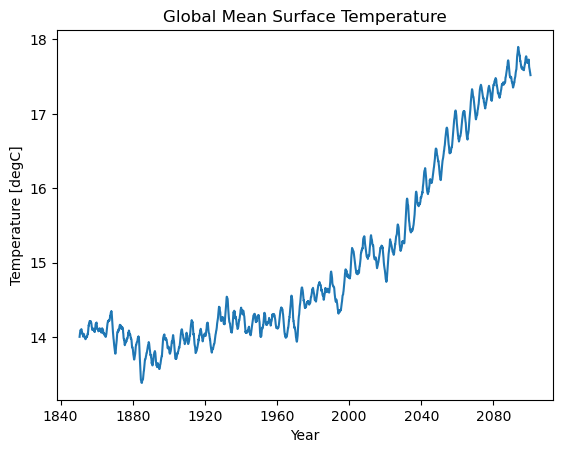

In [23]:
#Take a look at the Mean Global Temperature Trend

cell_area = cell_weight(ds_all,var)

plt.plot(ds_all.time, ds_all.tas.weighted(cell_area).mean(dim = ["lat", "lon"]).rolling(time = 12, center = True).mean())

plt.title("Global Mean Surface Temperature")
plt.xlabel("Year")
plt.ylabel("Temperature [degC]")

Text(0, 0.5, 'Temperature [degC]')

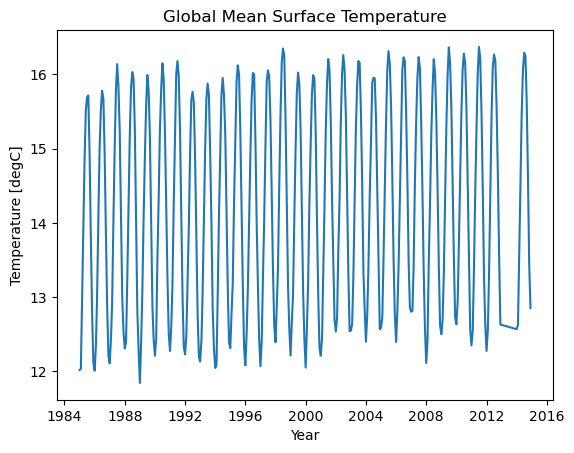

In [24]:
#Take a look at the Mean Global Temperature Trend

cell_area = cell_weight(ds_rean,var)

plt.plot(ds_rean.time, ds_rean.tas.weighted(cell_area).mean(dim = ["lat", "lon"]))

plt.title("Global Mean Surface Temperature")
plt.xlabel("Year")
plt.ylabel("Temperature [degC]")

We want to compute the Global Warming Trend since the Preindustrial period (1850-1900), thus we need to Normalize our time-series for the 1850-1900 climatological mean and standard deviation

Text(0, 0.5, 'Temperature [degC]')

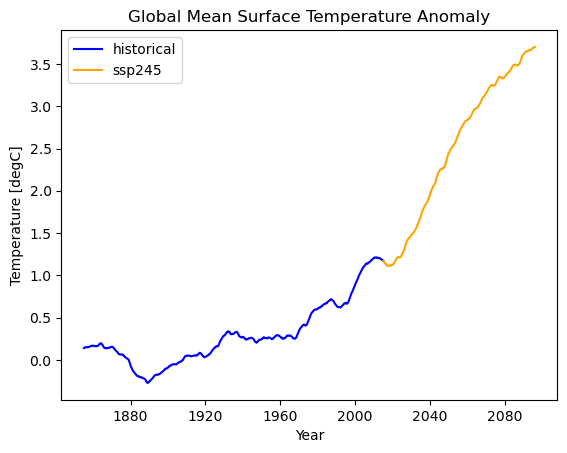

In [25]:
ds_globe = ds_all.copy()
cell_area = cell_weight(ds_globe,var)

ds_globe = ds_globe.weighted(cell_area).mean(dim = ["lat", "lon"])
ds_globe = (ds_globe - ds_globe.sel(time = slice("1850-01","1899-12")).mean())#/ds_globe.sel(time = slice("1850-01","1899-12")).std()
ds_globe = ds_globe.rolling(time = 120, center = True).mean()

plt.plot(ds_globe["time"].sel(time = slice("1850-01","2014-12")), ds_globe[var].sel(time = slice("1850-01","2014-12")), color = "blue")
plt.plot(ds_globe["time"].sel(time = slice("2015-01","2099-12")), ds_globe[var].sel(time = slice("2015-01","2099-12")), color = "orange")

plt.legend(["historical","ssp245"])

plt.title("Global Mean Surface Temperature Anomaly")
plt.xlabel("Year")
plt.ylabel("Temperature [degC]")

Compute the same for the Mediterranean Region: `Lon`=(-10, 43), `Lat`=(25, 48)

We need here to roll the longitude values from 0,360 to -180, 180

Text(0, 0.5, 'Temperature [degC]')

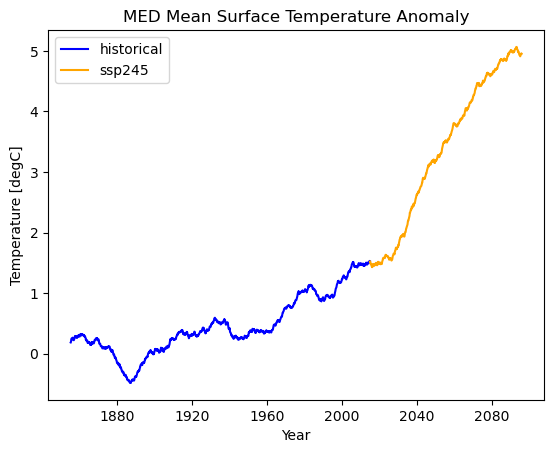

In [26]:
ds_med = ds_all.copy()
cell_area = cell_weight(ds_med,var)

ds_med.coords['lon'] = (ds_med.coords['lon'] + 180) % 360 - 180
ds_med = ds_med.sortby(ds_med.lon)

ds_med = ds_med.sel(lon=slice(-10,43),lat=slice(25,48)).mean(dim = ["lat", "lon"])
ds_med = (ds_med - ds_med.sel(time = slice("1850-01","1899-12")).mean())#/ds_med.sel(time = slice("1850-01","1899-12")).std()
ds_med = ds_med.rolling(time = 120, center = True).mean()

plt.plot(ds_med["time"].sel(time = slice("1850-01","2014-12")), ds_med[var].sel(time = slice("1850-01","2014-12")), color = "blue")
plt.plot(ds_med["time"].sel(time = slice("2015-01","2099-12")), ds_med[var].sel(time = slice("2015-01","2099-12")), color = "orange")

plt.legend(["historical","ssp245"])

plt.title("MED Mean Surface Temperature Anomaly")
plt.xlabel("Year")
plt.ylabel("Temperature [degC]")